In [0]:
import pandas as pd

In [0]:
pd_train = pd.read_csv("Dataset/arxiv/train_all.csv",dtype="str")

In [0]:
pd_test = pd.read_csv("Dataset/arxiv/test_all.csv",dtype="str")

In [0]:
pd_train.shape

(200092, 10)

In [0]:
pd_test.shape

(37125, 10)

Clean up abstract using noun only phrase

In [0]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
#abs_noun_clean = abstract_noun.apply(lambda x:alphabetic_only_l(x))

In [0]:
#abs_noun_clean_test = abstract_noun_test.apply(lambda x:alphabetic_only_l(x))

In [0]:
import pickle
#with open("Dataset/arxiv/abstract_noun_clean.pickle","wb") as file:
#  pickle.dump((abs_noun_clean,abs_noun_clean_test),file)
with open("Dataset/arxiv/abstract_noun_clean_strat.pickle","rb") as file:
  (abs_noun_clean,abs_noun_clean_test) = pickle.load(file)

In [0]:
# clean abstract noun so it will contain only alphabetic char

# use english stop_words
stop_words =  list(stopwords.words('english'))

def alphabetic_only_l(x_string):
  list_sent = []    
  for word in x_string.lower().split(" "):
    # remove all tokens that are not alphabetic
    #print(tokens)
    if word.isalpha() and word not in stop_words:
      list_sent.append(word)
  return " ".join(list_sent)

In [0]:
# features/words chooser using tfidf
def sent_convert(x_string):
  list_sent = []
  for sent in x_string:
    # remove all tokens that are not alphabetic    
    list_sent.append(" ".join(sent))    
  return " ".join(list_sent)

abs_noun_sent = abs_noun_clean.apply(lambda x:sent_convert(x))

In [0]:
pd_train.iloc[9].title

'Wavelets and graph $C^*$-algebras'

In [0]:
title_clean = pd_train.title.apply(lambda x:alphabetic_only_l(x))

In [0]:
title_clean.head()

0    combinatorial formulas certain sequences multi...
1    efficient symmetrized dmrg algorithm excited s...
2    study seyfert galaxies strong lines using larg...
3             note proper affine symmetry bianchi type
4                rapid rotational relaxation magnetars
Name: title, dtype: object

In [0]:
abs_noun_sent_test = abs_noun_clean_test.apply(lambda x:sent_convert(x))

In [0]:
title_clean_test = pd_test.title.apply(lambda x:alphabetic_only_l(x))

In [0]:
abs_noun_title = title_clean +" "+abs_noun_sent

In [0]:
abs_noun_title_test = title_clean_test +" "+abs_noun_sent_test

In [0]:
title_clean.shape

(200092,)

In [0]:
pd_train.iloc[60725].title

'On unconditional well-posedness for the periodic modified korteweg-de\n  vries equation'

In [0]:
abs_noun_sent[60725]

'equation '

In [0]:
# make 150 convolutional layer input

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
tfidf = tfidf_vectorizer.fit_transform(abs_noun_sent.values)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [0]:
title_vectorizer = CountVectorizer(max_df=0.95, min_df=2,max_features=10000)
title_vector = title_vectorizer.fit_transform(title_clean.values)
title_Feature_names = title_vectorizer.get_feature_names()

In [0]:
from scipy.sparse import lil_matrix
my_l_matrix = lil_matrix((pd_train.shape[0],150),dtype=int)

In [0]:
my_test_matrix = lil_matrix((pd_test.shape[0],150),dtype=int)

In [0]:
# get only 10000 tfidf most valuable features
tfidf_sum = tfidf.sum(axis=0)
import numpy as np
# sort the tfidf_desc
index_sort = np.argsort(tfidf_sum)[:,::-1]
pot_feat = [tfidf_feature_names[x] for x in index_sort.tolist()[0][:10000]]

In [0]:
pot_feat.extend(title_Feature_names)
pot_feat = list(set(pot_feat))
print(len(pot_feat))

13226


In [0]:
tf_feature_dict = {}
for i,x in enumerate(pot_feat):
  tf_feature_dict[x] = i+1

In [0]:
tf_embedding_dict = {}
for i,x in enumerate(pot_feat):
  tf_embedding_dict[x] = {"idx": i+1,"v":[]}

Make Embedding weights from fastext

In [0]:

#get only feature from the tf_feature_dict

# index words from word2vec
word_vector = []
tfidf_counter = 0
with open("Dataset/arxiv/cc.en.300.vec","r") as file:
  i = 0
  for vec in file:
    i+=1
    if i%100000==0:
      print(i)
    #word_index.append((vec.split(" ")[0],i))
    vec = vec.replace("\n","")
    word_idx = vec.split(" ")[0]
    word_coef = np.asarray(vec.split(" ")[1:], dtype='float32')
    try:
      tf_embedding_dict[word_idx]["v"] = word_coef
    except:
      continue

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000


In [0]:
np.sum([1 if len(x[1]["v"])>0 else 0 for x in tf_embedding_dict.items()])

12193

In [0]:
embedding_temp = []
for x in tf_embedding_dict.items():
  if len(x[1]["v"])>0:
    embedding_temp.append((x[0],x[1]["v"]))

In [0]:
embedding_temp[7]

('polymorphism',
 array([ 0.0821, -0.0309,  0.0137,  0.0069,  0.0241, -0.06  ,  0.0069,
        -0.0267,  0.0173,  0.0043, -0.0537, -0.0213, -0.0666,  0.0031,
        -0.0398, -0.0213, -0.0175,  0.0168,  0.0611, -0.0029,  0.0215,
        -0.0581, -0.0369, -0.0627,  0.0249, -0.0389,  0.0304,  0.0494,
         0.0238,  0.0906, -0.0115,  0.0435,  0.065 , -0.0114, -0.0442,
        -0.0031,  0.0356, -0.025 , -0.0342, -0.0772, -0.0277,  0.0397,
         0.0167, -0.031 , -0.0162, -0.0022, -0.0256,  0.0405, -0.0115,
        -0.0068,  0.0722, -0.042 , -0.0117,  0.041 , -0.045 ,  0.0351,
        -0.0092, -0.0058, -0.0423,  0.0201,  0.0484, -0.0335,  0.0039,
        -0.0098, -0.0092,  0.0251,  0.0297,  0.0069, -0.0536, -0.0316,
         0.0126, -0.0769,  0.0239,  0.002 , -0.0753,  0.0217,  0.0268,
         0.0172, -0.0294, -0.005 ,  0.0432,  0.0612, -0.0404,  0.0735,
        -0.0196,  0.0475,  0.0076, -0.0299, -0.0306,  0.006 , -0.0052,
         0.0372, -0.0098, -0.0491,  0.0533,  0.024 , -0.0081

In [0]:
tf_feature_dict = {}
for i,x in enumerate(embedding_temp):
  tf_feature_dict[x[0]] = i+1

In [0]:
embedding_weights = np.zeros((len(tf_feature_dict)+1,300))
for i,x in enumerate(embedding_temp):
  embedding_weights[i+1,:] = x[1]

In [0]:
embedding_weights.shape

(12194, 300)

In [0]:
import pickle
#with open("Dataset/arxiv/embed_weights.pickle","wb") as file:
#  pickle.dump((tf_feature_dict,embedding_weights),file)
with open("Dataset/arxiv/embed_weights.pickle","rb") as file:
  (tf_feature_dict,embedding_weights) = pickle.load(file)


In [0]:
from scipy.sparse import lil_matrix
my_l_matrix = lil_matrix((pd_train.shape[0],150),dtype=int)

In [0]:
my_test_matrix = lil_matrix((pd_test.shape[0],150),dtype=int)

In [0]:
max = 150
for i,x in enumerate(abs_noun_title.values):  
  #if i < 64470:
  #  continue
  if i % 10000 == 0:
    print(i,end=" ")
  x = x.split(" ")
  len_x = len(x) if len(x) < 150 else 150
  #print(len_x)
  feat_x = []
  for my_x in x[:len_x]:
    if len(my_x) > 0:
      try:
        feat_x.append(tf_feature_dict[my_x])
      except:
        pass
        #feat_x.append(0)
      #if my_x in tf_feature_names:
      #  feat_x.append(tf_feature_names.index(my_x))
      #else:
      #  feat_x.append(0)
  #print(feat_x)
  if len(feat_x) > 0:
    my_l_matrix[i,-len(feat_x):] = feat_x
  #print(seq_matrix[i])
  #break

0 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 

In [0]:
max = 150
for i,x in enumerate(abs_noun_title_test.values):  
  #if i < 64470:
  #  continue
  if i % 10000 == 0:
    print(i,end=" ")
  x = x.split(" ")
  len_x = len(x) if len(x) < 150 else 150
  #print(len_x)
  feat_x = []
  for my_x in x[:len_x]:
    if len(my_x) > 0:
      try:
        feat_x.append(tf_feature_dict[my_x])
      except:
        #feat_x.append(0)
        pass
      #if my_x in tf_feature_names:
      #  feat_x.append(tf_feature_names.index(my_x))
      #else:
      #  feat_x.append(0)
  #print(feat_x)
  if len(feat_x) > 0:
    my_test_matrix[i,-len(feat_x):] = feat_x
  #print(seq_matrix[i])
  #break

0 10000 20000 30000 

In [0]:
abs_noun_sent.iloc[:3].values

array(['analogues families numbers author terms macdonald functions properties paper formulas well macdonald functions coefficients bracket function catalan numbers ',
       'symmetry density matrix renormalization group sdmrg technique method eigenstates systems method bottlenecks construction symmetry basis states symmetry matrices basis algorithm bottleneck method interchange symmetry hole symmetry parity symmetry calculations correspondence basis states dmrg space symmetry operations symmetry matrices basis sparseness matrix element methods diagonalization technique models eighties basis states step orthonormalization procedure method model correlations state spectrum coronene coronene ovalene polyenes correlation parameters model ordering states systems correlation parameters orbitals model ordering states systems importance topology term model molecules detail properties states molecules ',
       'radio properties galaxies lines fhils sloan survey sample proportion range galaxi

In [0]:
my_l_matrix[:3,].data

array([list([9945, 8122, 10030, 9177, 12033, 1505, 2695, 1492, 1505, 8616, 9498, 5198, 3602, 7695, 992, 8122, 2571, 5198, 3602, 9606, 9023, 9034, 9870, 1505]),
       list([10313, 11720, 9648, 4176, 1515, 5994, 12002, 2295, 4447, 10563, 12110, 5114, 11966, 1123, 4299, 9987, 6445, 4299, 9793, 5278, 4447, 8739, 1515, 4447, 1227, 8739, 9648, 9899, 4299, 10164, 4447, 6626, 4447, 10036, 4447, 10411, 479, 8739, 1515, 4673, 4447, 7393, 4447, 1227, 8739, 11687, 12110, 11279, 455, 11395, 1123, 5026, 8739, 1515, 11625, 8551, 4299, 11590, 10728, 308, 11071, 11134, 3524, 11590, 8036, 1515, 6445, 11134, 3524, 1622, 11590, 8036, 1515, 6445, 10977, 8830, 8502, 11590, 9968, 11410, 7695, 1515, 9968]),
       list([1846, 6234, 10839, 5989, 10937, 6340, 10965, 10292, 5257, 8031, 7695, 6234, 5989, 2582, 10292, 6037, 7236, 6177, 6234, 4696, 9137, 10965, 10292, 5257, 8031, 6948, 8245, 6948, 8245, 4610, 1839, 6234, 5335, 10717, 1302, 8031, 6566, 715, 7977, 6566, 8599, 11586, 9541, 6357, 8031, 6948, 8245, 913

In [0]:
import numpy as np
np.sum(my_l_matrix[:,149]==0)

/usr/local/lib/python3.6/dist-packages/scipy/sparse/compressed.py:214: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  ", try using != instead.", SparseEfficiencyWarning)


0

In [0]:
my_test_matrix.shape

(37125, 150)

In [0]:
!pip install tflearn

    100% |████████████████████████████████| 102kB 3.0MB/s 
  Running setup.py bdist_wheel for tflearn ... - \ done
  Stored in directory: /root/.cache/pip/wheels/d0/f6/69/0ef3ee395aac2e5d15d89efd29a9a216f3c27767b43b72c006
Successfully built tflearn


In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tflearn.data_utils import to_categorical, pad_sequences
from keras.models import Model


Using TensorFlow backend.


In [0]:
y_train_label = pd_train.cats.apply(lambda x: x.split("|")[0])

In [0]:
pd_train.shape

(200092, 10)

In [0]:
y_train_label_l = list(y_train_label.unique())

In [0]:
y_train_class = y_train_label.apply(lambda x:y_train_label_l.index(x))

In [0]:
from keras.layers import Input
from keras.layers import Dropout
sequence_input = Input(shape=(max,), dtype='int32',name="input")
embedded_sequences = Embedding(input_dim=len(tf_feature_dict)+1,output_dim=300,weights=[embedding_weights],name="embedding",trainable=False)(sequence_input)
l_cov1 = Conv1D(512, 3, activation='relu',name="cov1")(embedded_sequences)
l_pool1 = MaxPooling1D(2,name="pool1")(l_cov1)
dropout1 = Dropout(0.2,name="dropout1")(l_pool1)
l_lstm= LSTM(units=150,name="lstm1")(dropout1)
dropout2 = Dropout(0.2,name="dropout2")(l_lstm)
#l_cov2 = Conv1D(256, 3, activation='tanh',name="cov2")(dropout2)
#l_cov3 = Conv1D(512, 2, activation='relu',name="cov3")(l_cov2)
#l_pool2 = MaxPooling1D(2,name="pool2")(l_cov2)
#dropout3 = Dropout(0.2,name="dropout4")(l_pool2)
#l_flat = Flatten(name="flatten")(dropout2)
l_dense1 = Dense(256, activation='relu',name="dense1")(dropout2)
dropout4 = Dropout(0.2,name="dropout3")(l_dense1)
l_dense2 = Dense(128, activation='relu',name="dense2")(dropout4)
preds = Dense(len(y_train_label_l), activation='softmax',name="output")(l_dense2)

In [0]:
model = Model(input=sequence_input, output=preds)

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`
  """Entry point for launching an IPython kernel.


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 150)               0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 300)          3658200   
_________________________________________________________________
cov1 (Conv1D)                (None, 148, 512)          461312    
_________________________________________________________________
pool1 (MaxPooling1D)         (None, 74, 512)           0         
_________________________________________________________________
dropout1 (Dropout)           (None, 74, 512)           0         
_________________________________________________________________
lstm1 (LSTM)                 (None, 150)               397800    
_________________________________________________________________
dropout2 (Dropout)           (None, 150)               0         
__________

In [0]:
y_test_class = pd_test.cats.apply(lambda x: x.split("|")[0]).apply(lambda x:y_train_label_l.index(x))

In [0]:
y_test_one_hot = to_categorical(y_test_class.values,20)

In [0]:
from sklearn.model_selection import train_test_split, StratifiedKFold

import numpy as np
mini_batch = 20000
total_docs = my_l_matrix.shape[0]
total_batch = int(my_l_matrix.shape[0]/mini_batch)+1
#range_docs = range(0,total_docs)
#range_docs = train


for it in range(5):
  k_sample = StratifiedKFold(n_splits=total_batch, shuffle=True, random_state=1).split(range(len(y_train_class.values)), y_train_class.values)
  for batch in k_sample:
      # random sample dataset
      #r_index = random.sample(list(range_docs),mini_batch)
      #r_index_start = mini_batch*batch
      #r_index_end = mini_batch*(batch+1) if batch<total_batch-1 else total_docs
      X_batch = my_l_matrix[batch[1],:]
      #y_batch = dataset.iloc[r_index].subjects.apply(lambda x:labeling_subjects(x))
      #y_batch = np.array([])
      #for x in dataset.iloc[r_index].subjects:
      #    y_batch = np.append(y_batch,labeling_subjects(x),axis=0)
      #y_batch
      #y_batch = y_batch.reshape(len(r_index),len(label_class))
      y_batch = to_categorical(y_train_class[batch[1]].values,20)

      model.fit(X_batch,y_batch,epochs=1,batch_size=1000)
  y_pred = np.argmax(model.predict(my_test_matrix),axis=1)
  from sklearn.metrics import classification_report,accuracy_score,cohen_kappa_score
  acc = accuracy_score(y_test_class,y_pred)
  kap = cohen_kappa_score(y_test_class,y_pred)
  print("accuracy:",acc)
  print("kappa:",kap)
  print(classification_report(y_test_class,y_pred))
  model.save("Dataset/arxiv/nn-model-lstm-embed-{}.h5".format(it))

Epoch 1/1
18195/18195 [==============================] - 17s 917us/step - loss: 2.4333 - acc: 0.2664
Epoch 1/1
18195/18195 [==============================] - 11s 611us/step - loss: 1.5814 - acc: 0.5538
Epoch 1/1
18195/18195 [==============================] - 12s 649us/step - loss: 1.3023 - acc: 0.6121
Epoch 1/1
18195/18195 [==============================] - 11s 603us/step - loss: 1.1274 - acc: 0.6607
Epoch 1/1
18193/18193 [==============================] - 12s 666us/step - loss: 1.0419 - acc: 0.6833
Epoch 1/1
18191/18191 [==============================] - 11s 607us/step - loss: 0.9687 - acc: 0.7092
Epoch 1/1
18190/18190 [==============================] - 12s 672us/step - loss: 0.9038 - acc: 0.7248
Epoch 1/1
18190/18190 [==============================] - 11s 599us/step - loss: 0.8728 - acc: 0.7288
Epoch 1/1
18188/18188 [==============================] - 12s 665us/step - loss: 0.8400 - acc: 0.7396
Epoch 1/1
18182/18182 [==============================] - 11s 598us/step - loss: 0.8156 - ac

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 1/1
18195/18195 [==============================] - 12s 632us/step - loss: 0.7864 - acc: 0.7533
Epoch 1/1
18195/18195 [==============================] - 12s 637us/step - loss: 0.7741 - acc: 0.7558
Epoch 1/1
18195/18195 [==============================] - 10s 573us/step - loss: 0.7608 - acc: 0.7586
Epoch 1/1
18195/18195 [==============================] - 10s 573us/step - loss: 0.7454 - acc: 0.7617
Epoch 1/1
18193/18193 [==============================] - 10s 573us/step - loss: 0.7183 - acc: 0.7674
Epoch 1/1
18191/18191 [==============================] - 10s 573us/step - loss: 0.7318 - acc: 0.7629
Epoch 1/1
18190/18190 [==============================] - 10s 573us/step - loss: 0.7106 - acc: 0.7770
Epoch 1/1
18190/18190 [==============================] - 10s 572us/step - loss: 0.7093 - acc: 0.7688
Epoch 1/1
18188/18188 [==============================] - 10s 572us/step - loss: 0.6970 - acc: 0.7734
Epoch 1/1
18182/18182 [==============================] - 10s 572us/step - loss: 0.7012 - ac

In [0]:
for it in range(10):
  k_sample = StratifiedKFold(n_splits=total_batch, shuffle=True, random_state=1).split(range(len(y_train_class.values)), y_train_class.values)
  for batch in k_sample:
      X_batch = my_l_matrix[batch[1],:]
      y_batch = to_categorical(y_train_class[batch[1]].values,20)

      model.fit(X_batch,y_batch,epochs=1,batch_size=200)
  y_pred = np.argmax(model.predict(my_test_matrix),axis=1)
  from sklearn.metrics import classification_report,accuracy_score,cohen_kappa_score
  acc = accuracy_score(y_test_class,y_pred)
  kap = cohen_kappa_score(y_test_class,y_pred)
  print("accuracy:",acc)
  print("kappa:",kap)
  print(classification_report(y_test_class,y_pred))
  model.save("Dataset/arxiv/nn-model-lstm-embed-b{}.h5".format(it))

Epoch 1/1
18195/18195 [==============================] - 24s 1ms/step - loss: 0.6257 - acc: 0.7946
Epoch 1/1
18195/18195 [==============================] - 23s 1ms/step - loss: 0.6243 - acc: 0.7935
Epoch 1/1
18195/18195 [==============================] - 24s 1ms/step - loss: 0.6187 - acc: 0.7958
Epoch 1/1
18195/18195 [==============================] - 24s 1ms/step - loss: 0.6101 - acc: 0.7994
Epoch 1/1
18193/18193 [==============================] - 23s 1ms/step - loss: 0.5919 - acc: 0.8004
Epoch 1/1
18191/18191 [==============================] - 23s 1ms/step - loss: 0.5999 - acc: 0.7999
Epoch 1/1
18190/18190 [==============================] - 24s 1ms/step - loss: 0.5951 - acc: 0.8054
Epoch 1/1
18190/18190 [==============================] - 24s 1ms/step - loss: 0.5761 - acc: 0.8048
Epoch 1/1
18188/18188 [==============================] - 24s 1ms/step - loss: 0.5816 - acc: 0.8022
Epoch 1/1
18182/18182 [==============================] - 24s 1ms/step - loss: 0.5693 - acc: 0.8126
Epoch 1/1


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 1/1
18195/18195 [==============================] - 24s 1ms/step - loss: 0.5380 - acc: 0.8193
Epoch 1/1
18195/18195 [==============================] - 24s 1ms/step - loss: 0.5362 - acc: 0.8199
Epoch 1/1
18195/18195 [==============================] - 24s 1ms/step - loss: 0.5421 - acc: 0.8193
Epoch 1/1
18195/18195 [==============================] - 24s 1ms/step - loss: 0.5319 - acc: 0.8221
Epoch 1/1
18193/18193 [==============================] - 24s 1ms/step - loss: 0.5326 - acc: 0.8199
Epoch 1/1
18191/18191 [==============================] - 24s 1ms/step - loss: 0.5365 - acc: 0.8188
Epoch 1/1
18190/18190 [==============================] - 24s 1ms/step - loss: 0.5305 - acc: 0.8212
Epoch 1/1
18190/18190 [==============================] - 24s 1ms/step - loss: 0.5222 - acc: 0.8230
Epoch 1/1
18188/18188 [==============================] - 23s 1ms/step - loss: 0.5238 - acc: 0.8244
Epoch 1/1
18182/18182 [==============================] - 24s 1ms/step - loss: 0.5171 - acc: 0.8263
Epoch 1/1


In [0]:
for it in range(10):
  k_sample = StratifiedKFold(n_splits=total_batch, shuffle=True, random_state=1).split(range(len(y_train_class.values)), y_train_class.values)
  for batch in k_sample:
      X_batch = my_l_matrix[batch[1],:]
      y_batch = to_categorical(y_train_class[batch[1]].values,20)

      model.fit(X_batch,y_batch,epochs=1,batch_size=200)
  y_pred = np.argmax(model.predict(my_test_matrix),axis=1)
  from sklearn.metrics import classification_report,accuracy_score,cohen_kappa_score
  acc = accuracy_score(y_test_class,y_pred)
  kap = cohen_kappa_score(y_test_class,y_pred)
  print("accuracy:",acc)
  print("kappa:",kap)
  print(classification_report(y_test_class,y_pred))
  model.save("Dataset/arxiv/nn-model-lstm-embed-c{}.h5".format(it))

Epoch 1/1
18195/18195 [==============================] - 24s 1ms/step - loss: 0.2748 - acc: 0.9015
Epoch 1/1
18195/18195 [==============================] - 24s 1ms/step - loss: 0.2736 - acc: 0.9001
Epoch 1/1
18195/18195 [==============================] - 23s 1ms/step - loss: 0.2556 - acc: 0.9081
Epoch 1/1
18195/18195 [==============================] - 24s 1ms/step - loss: 0.2547 - acc: 0.9089
Epoch 1/1
18193/18193 [==============================] - 24s 1ms/step - loss: 0.2619 - acc: 0.9055
Epoch 1/1
18191/18191 [==============================] - 23s 1ms/step - loss: 0.2666 - acc: 0.9031
Epoch 1/1
18190/18190 [==============================] - 24s 1ms/step - loss: 0.2601 - acc: 0.9051
Epoch 1/1
18190/18190 [==============================] - 24s 1ms/step - loss: 0.2688 - acc: 0.9025
Epoch 1/1
18188/18188 [==============================] - 24s 1ms/step - loss: 0.2435 - acc: 0.9121
Epoch 1/1
18182/18182 [==============================] - 24s 1ms/step - loss: 0.2555 - acc: 0.9081
Epoch 1/1


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 1/1
18195/18195 [==============================] - 24s 1ms/step - loss: 0.2571 - acc: 0.9077
Epoch 1/1
18195/18195 [==============================] - 24s 1ms/step - loss: 0.2584 - acc: 0.9050
Epoch 1/1
18195/18195 [==============================] - 24s 1ms/step - loss: 0.2418 - acc: 0.9116
Epoch 1/1
18195/18195 [==============================] - 24s 1ms/step - loss: 0.2462 - acc: 0.9127
Epoch 1/1
18193/18193 [==============================] - 41s 2ms/step - loss: 0.2417 - acc: 0.9125
Epoch 1/1
18191/18191 [==============================] - 36s 2ms/step - loss: 0.2477 - acc: 0.9078
Epoch 1/1
18190/18190 [==============================] - 23s 1ms/step - loss: 0.2430 - acc: 0.9121
Epoch 1/1
18190/18190 [==============================] - 24s 1ms/step - loss: 0.2381 - acc: 0.9130
Epoch 1/1
18188/18188 [==============================] - 24s 1ms/step - loss: 0.2328 - acc: 0.9165
Epoch 1/1
18182/18182 [==============================] - 24s 1ms/step - loss: 0.2375 - acc: 0.9149
Epoch 1/1


In [0]:
from keras.models import load_model
model2 = load_model("Dataset/arxiv/nn-model-conv7c-4.h5")
#model.load_weights("Dataset/arxiv/nn-model-conv6b-1.h5")

In [0]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 150)               0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 300)          3968100   
_________________________________________________________________
dropout1 (Dropout)           (None, 150, 300)          0         
_________________________________________________________________
conv1 (Conv1D)               (None, 146, 256)          384256    
_________________________________________________________________
pool1 (MaxPooling1D)         (None, 48, 256)           0         
_________________________________________________________________
dropout2 (Dropout)           (None, 48, 256)           0         
_________________________________________________________________
cov2 (Conv1D)                (None, 46, 256)           196864    
__________

In [0]:
from sklearn.metrics import confusion_matrix
import itertools
from matplotlib import pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

In [0]:
y_pred = np.argmax(model2.predict(my_test_matrix),axis=1)
from sklearn.metrics import classification_report,accuracy_score,cohen_kappa_score
acc = accuracy_score(y_test_class,y_pred)
kap = cohen_kappa_score(y_test_class,y_pred)
print("accuracy:",acc)
print("kappa:",kap)
print(classification_report(y_test_class,y_pred,target_names=y_train_label_l))

accuracy: 0.8007272727272727
kappa: 0.7655796878120434
             precision    recall  f1-score   support

       math       0.87      0.89      0.88      9054
    physics       0.66      0.56      0.61      3187
   astro-ph       0.92      0.93      0.92      3980
      gr-qc       0.60      0.73      0.66       798
     hep-th       0.74      0.68      0.71      1065
    nucl-th       0.66      0.60      0.63       379
       stat       0.62      0.47      0.54      1204
   cond-mat       0.80      0.87      0.84      4324
         cs       0.83      0.89      0.86      8125
     hep-ph       0.83      0.77      0.80      1354
    nucl-ex       0.38      0.52      0.44       132
      q-fin       0.72      0.60      0.65       214
   quant-ph       0.77      0.71      0.74      1498
    math-ph       0.31      0.27      0.29       442
       nlin       0.52      0.35      0.42       261
      q-bio       0.54      0.53      0.54       504
     hep-ex       0.62      0.69      0.65 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Normalized confusion matrix


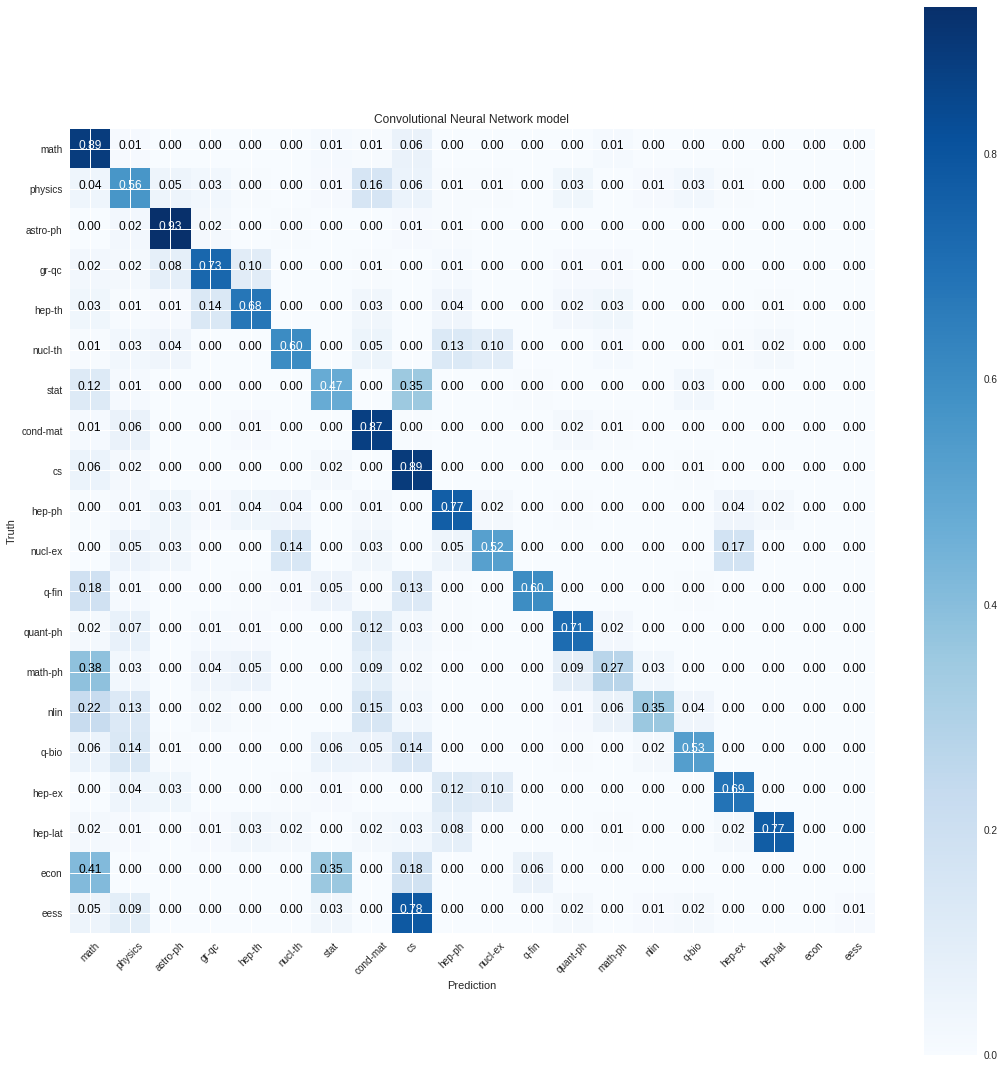

In [0]:
import numpy as np
cnf_matrix = confusion_matrix(y_test_class,y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=y_train_label_l, normalize=True,
                      title="{} model".format("Convolutional Neural Network"))